In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pathlib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
# # explore gradient boosting number of trees effect on performance
# from numpy import mean
# from numpy import std
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
 

In [3]:
# Set random seeds

sampling_seed = np.random.seed(13)
train_test_seed = np.random.seed(69)
cv_seed = np.random.seed(37)
model_seed = np.random.seed(73)
np.random.seed(42) # set default seed value

In [4]:
states = ['Gelderland', 'Zeeland', 'Utrecht', 'Overijssel', 'Limburg', 'Groningen', 'North Brabant']
# ['North Holland', 'Friesland', 'Drenthe', 'Flevoland']

In [5]:
state_names, state_paths = list(), list()
for state in states:
    state_name=state.lower().replace(' ', '_')
    state_path = pathlib.Path('model_performance/south_holland/run0/%s/' % (state_name))
    state_path.mkdir(parents=True, exist_ok=True)
    state_names.append(state_name)
    state_paths.append(state_path)
state_names

['gelderland',
 'zeeland',
 'utrecht',
 'overijssel',
 'limburg',
 'groningen',
 'north_brabant']

In [6]:
label_col = ["bldg_height"]
# num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
cat_cols = ["city", "postcode"]


In [7]:
def get_df(bq_table_name, sample_frac=None):
    query="""
    SELECT
      * EXCEPT(country, state_name)
    FROM
      `ual3d-277909.nl.%s`
    """ % (bq_table_name)
    full_df = bq.Client().query(query).to_dataframe()
    if sample_frac:
        part_df = full_df.sample(frac=sample_frac, random_state=sampling_seed)
        return part_df
    return full_df



In [8]:
def set_index(df, index_col):
    df.set_index(index_col, inplace=True)

In [9]:
def set_cat_and_list_unique(df, cat_cols):
    for col in cat_cols:
        df[col] = df[col].astype("category")
#         print(pd.unique(df[col]))

In [10]:
def explore_num_df(num_df, num_df_plot):
    num_df.describe()
    num_df.plot(kind='box', subplots=True, figsize=(24,9))
    plt.plot()
    plt.savefig(num_df_plot)

In [11]:
def list_basic_properties(df):
    set_index(df, 'osm_way_id')
    set_cat_and_list_unique(df, cat_cols)


In [12]:
def get_X_y(df):
    X = df.drop('bldg_height', axis=1).drop(['perimeter'], axis=1)
    y = df['bldg_height']
    return X, y

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler())])

freq_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1, add_indicator=True)),
    ('scaler', StandardScaler())])

zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
    ('scaler', StandardScaler())])

In [15]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [16]:

preprocessor = ColumnTransformer(transformers=[
        ('mean_transformer', mean_transformer, ["year"]),
        ('freq_transformer', freq_transformer, ["building_levels"]),
        ('zero_transformer', zero_transformer, ["count_neighbor"]),
        ('cat_transfomer', cat_transformer, cat_cols)], n_jobs=-1)

In [17]:
regressor = GradientBoostingRegressor(
    n_estimators=500, 
    learning_rate=0.1,
    subsample=0.6,
    max_depth=6,
    max_features=0.4,
    random_state=model_seed)

In [18]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])

In [19]:
def get_scores(X, y):
    pipeline.fit(X, y)
    y_pred = pipeline.predict(X)
    r2 = pipeline.score(X, y)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    return r2, mae, mse, mape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Gelderland :: MAE 2.137 | MSE 7.072 | R2 0.179 | MAPE inf


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Utrecht :: MAE 2.658 | MSE 9.600 | R2 0.124 | MAPE inf


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Overijssel :: MAE 2.262 | MSE 7.254 | R2 0.105 | MAPE inf


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Limburg :: MAE 2.366 | MSE 8.131 | R2 0.109 | MAPE inf


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Groningen :: MAE 2.302 | MSE 8.165 | R2 0.075 | MAPE inf


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


North Brabant :: MAE 2.456 | MSE 8.209 | R2 0.096 | MAPE inf


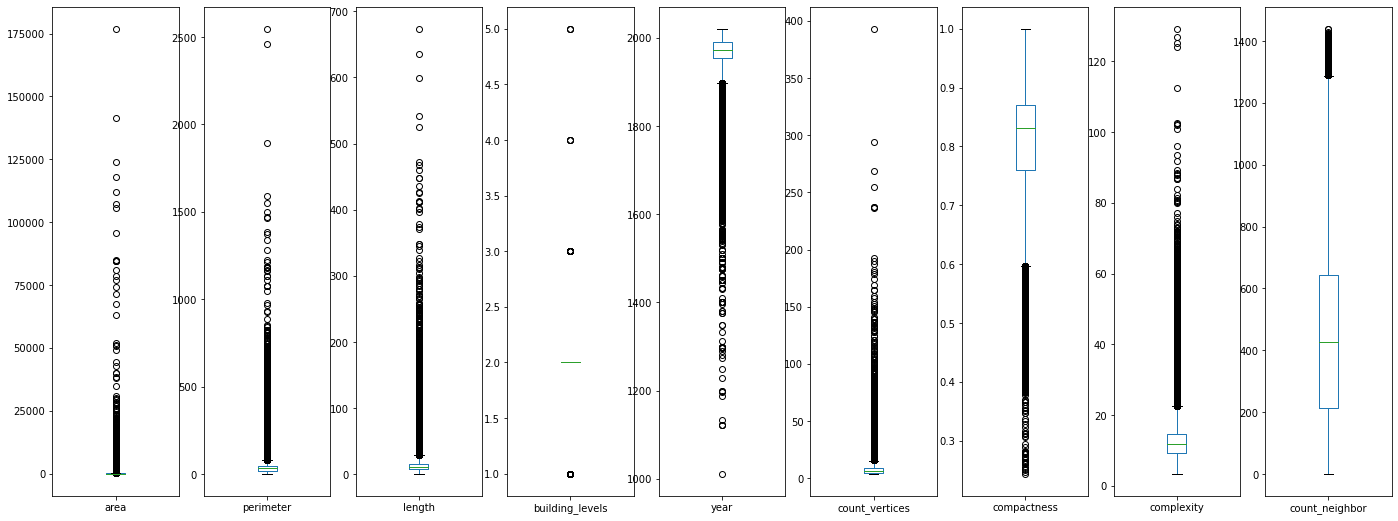

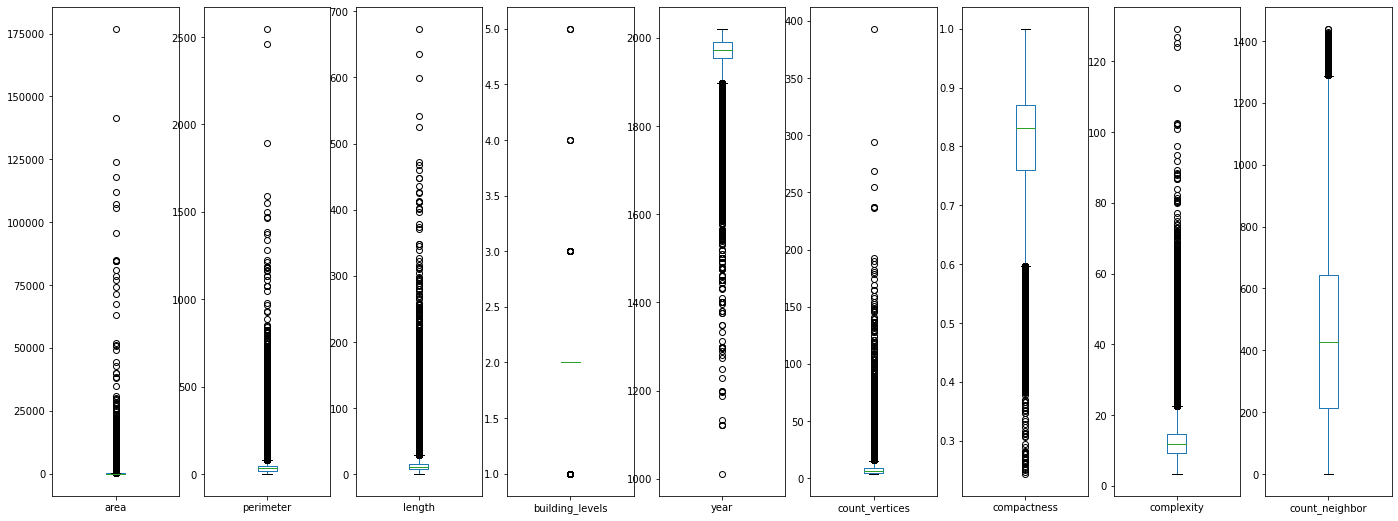

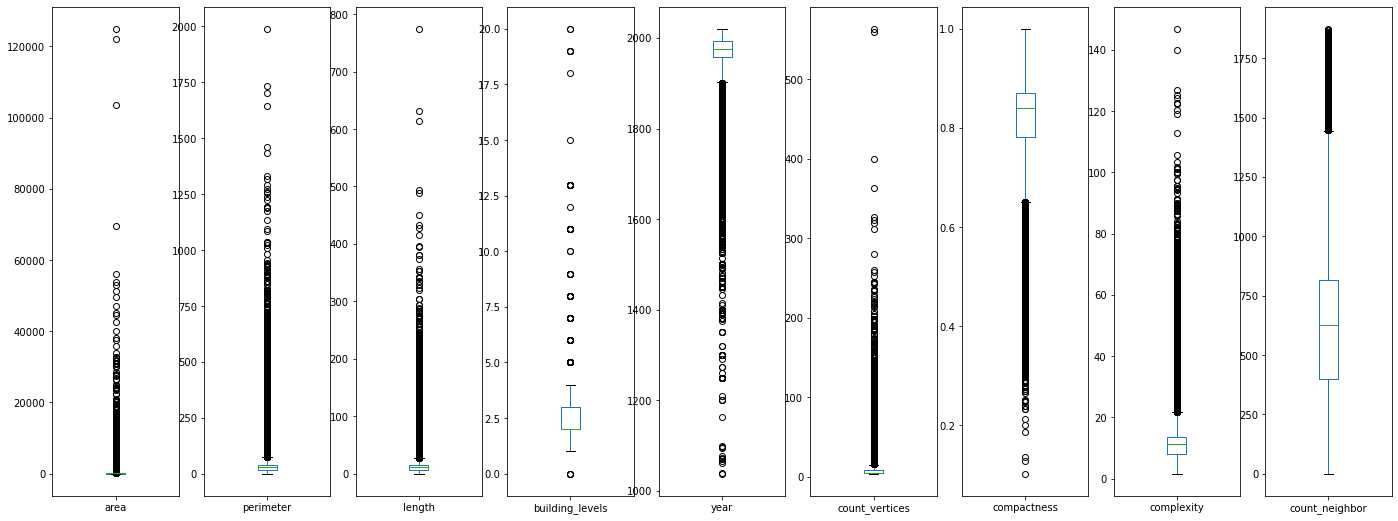

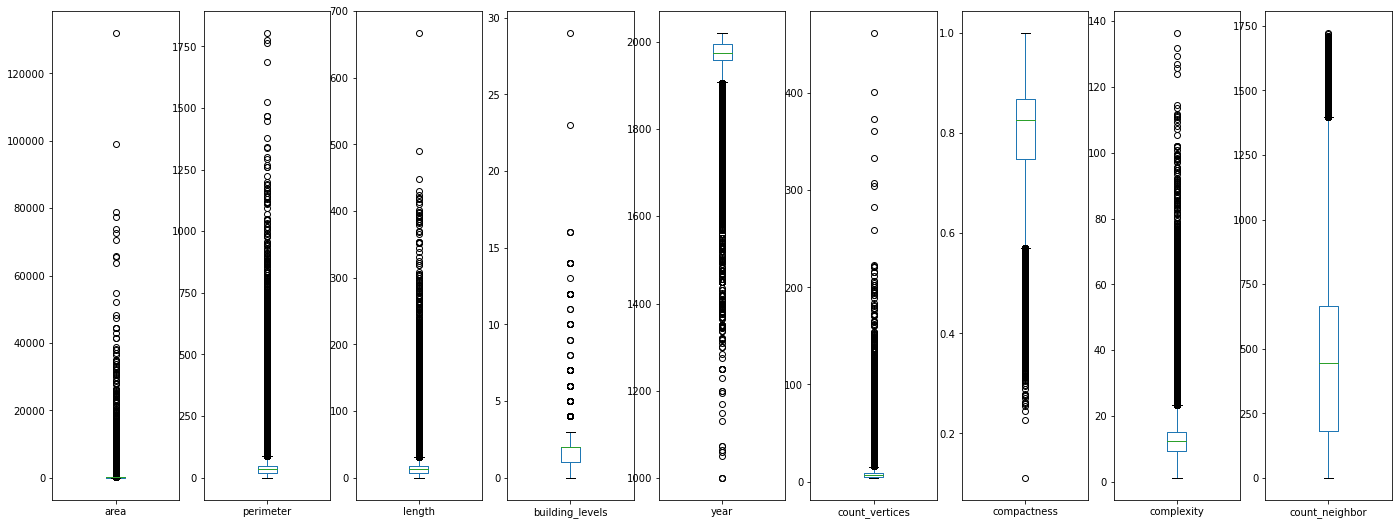

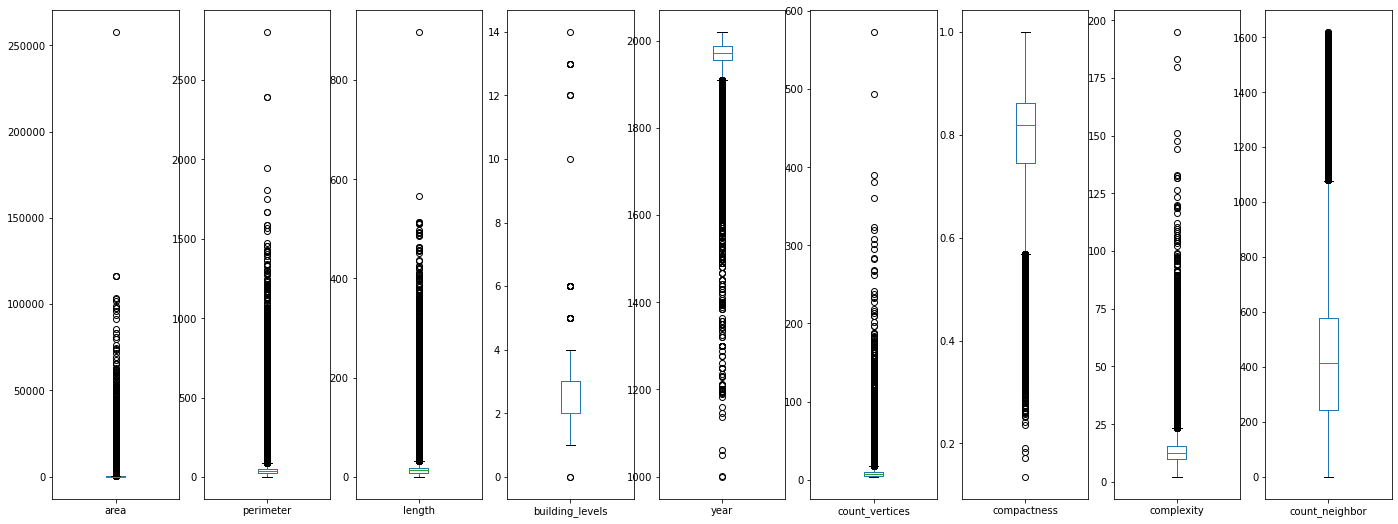

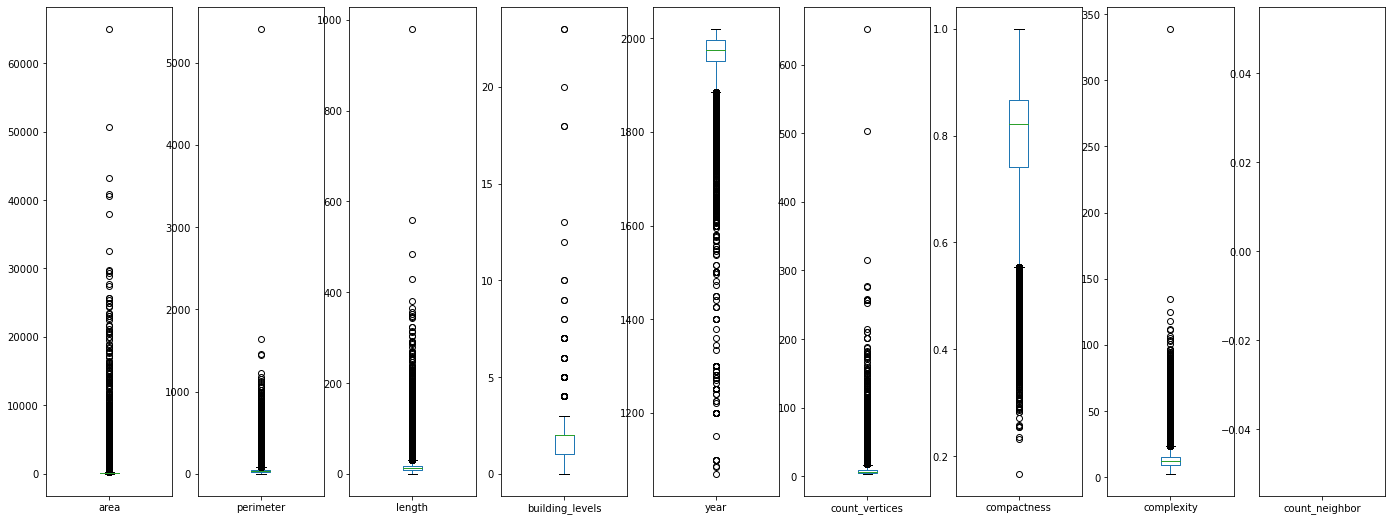

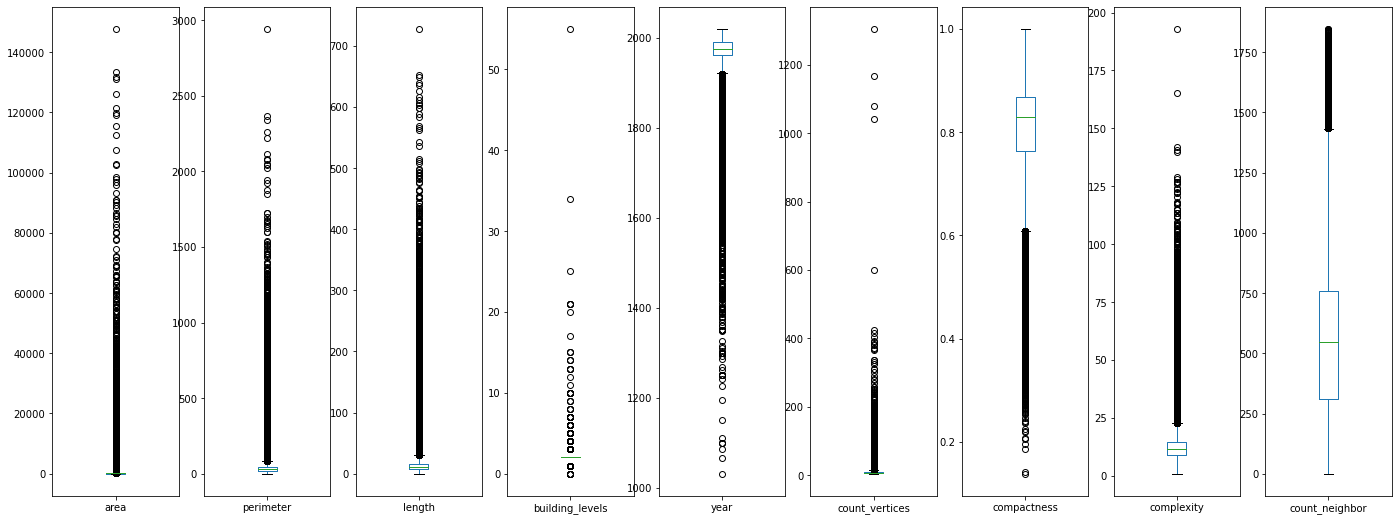

In [20]:
for idx, state_name in enumerate(state_names):
    bq_tbl_name = "%s_ml_df" % (state_name)
    df = get_df(bq_tbl_name)
    list_basic_properties(df)
    num_df = df[num_cols]
    num_df_plot = pathlib.Path(state_paths[idx], '%s_basic_distribution_null.png' % (state_name))
    explore_num_df(num_df, num_df_plot)
    X, y = get_X_y(df)
    r2, mae, mse, mape = get_scores(X, y)
    print('%s :: MAE %.3f | MSE %.3f | R2 %.3f | MAPE %.3f' % (states[idx], mae, mse, r2, mape))
    

In [20]:
bq_tbl_name = "%s_ml_df" % ('limburg')
bq_tbl_name

'limburg_ml_df'

In [21]:
df = get_df(bq_tbl_name)
df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,postcode,year,count_vertices,compactness,complexity,count_neighbor
0,279124181,2.94,38.578402,25.772180,9.452069,NaN,None,None,1947.0,6,0.854330,10.341061,188.0
1,666292701,0.14,148.535784,67.607709,23.587032,NaN,None,None,2019.0,13,0.639034,19.365934,151.0
2,296281977,11.06,351.095625,87.636060,29.611428,NaN,None,None,1480.0,11,0.757940,20.245406,4.0
3,278386552,8.50,220.559760,88.425996,34.397053,NaN,None,None,1714.0,8,0.595372,22.945546,10.0
4,277030425,8.12,157.748124,63.840539,24.067797,NaN,None,None,1915.0,9,0.697414,18.013807,375.0


In [22]:
list_basic_properties(df)


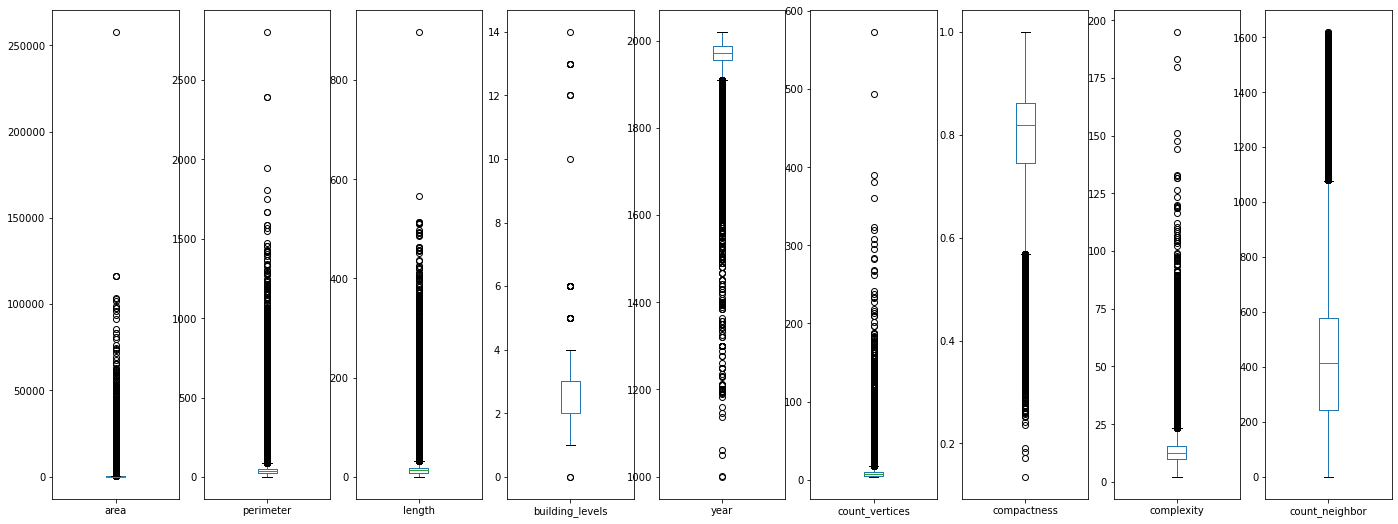

In [23]:
num_df = df[num_cols]
num_df_plot = pathlib.Path(state_paths[4], '%s_basic_distribution_null.png' % ('limburg'))
explore_num_df(num_df, num_df_plot)


In [24]:
X, y = get_X_y(df)
y
type(y)
type(np.array(y))

numpy.ndarray

In [25]:
pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('mean_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                     

In [26]:
y_pred = pipeline.predict(X)
y_pred


array([6.25261346, 0.46670802, 8.98231018, ..., 5.28160577, 4.97855978,
       4.64100647])

In [27]:
y.any(0)

True

In [35]:
y_diff = y - y_pred
y_diff

osm_way_id
280327604    1.230189
543764825   -2.813259
533973457   -0.422007
277092612   -4.677062
462074462   -0.167927
               ...   
597061537   -4.783134
448834618   -0.990787
625721982   -4.979911
450569917    4.808851
729657631   -1.251590
Name: bldg_height, Length: 683054, dtype: float64

In [36]:
type(y_diff)

pandas.core.series.Series

In [39]:
ratio = np.abs(y_diff) / y * 100
ratio

osm_way_id
280327604      12.514643
543764825     106.160707
533973457      11.921093
277092612     163.533645
462074462       2.822299
                ...     
597061537    4783.134428
448834618      24.769677
625721982    2766.617431
450569917      49.019891
729657631      32.424601
Name: bldg_height, Length: 683054, dtype: float64

False

In [48]:
np_ratio = np.array(ratio, dtype=np.float64)
type(np_ratio)

numpy.ndarray

In [49]:
mape = np_ratio.mean()
mape

inf

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
r2, mae, mse, mape = get_scores(X, y)
print('%s :: MAE %.3f | MSE %.3f | R2 %.3f | MAPE %.3f' % (states[4], mae, mse, r2, mape))

In [11]:
# ml_df = full_df.sample(frac=1, random_state=sampling_seed)
# ml_df.head()

In [6]:
ml_df = full_df
ml_df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
0,265305375,11.15,64.001453,34.842100,13.342338,NaN,None,NL,None,1880.0,7,0.813946,12.318473,925.0,North Holland
1,272628967,9.30,68.886436,40.001066,15.279231,NaN,None,NL,None,1911.0,8,0.735530,13.884752,687.0,North Holland
2,272680868,8.00,41.360271,25.795984,9.177766,NaN,None,NL,None,1949.0,5,0.883781,10.171998,1084.0,North Holland
3,284129509,2.75,11.620945,13.698119,4.877114,NaN,None,NL,None,1903.0,5,0.882195,7.419089,959.0,North Holland
4,273318454,9.52,760.358611,131.020189,52.490301,NaN,None,NL,None,2012.0,9,0.746064,24.950750,372.0,North Holland


In [7]:
ml_df.set_index('osm_way_id', inplace=True)

ml_df["city"] = ml_df["city"].astype("category")
ml_df["postcode"] = ml_df["postcode"].astype("category")
ml_df["country"] = ml_df["country"].astype("category")
ml_df["state_name"] = ml_df["state_name"].astype("category")

ml_df.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels     float64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [8]:
ml_df.shape

(1314524, 14)

In [9]:
ml_df.isna().sum()


bldg_height              0
area                     0
perimeter                0
length                   0
building_levels    1303332
city               1313298
country                  0
postcode           1313405
year                    43
count_vertices           0
compactness              0
complexity               0
count_neighbor         241
state_name               0
dtype: int64

In [10]:
print('unique city:', pd.unique(ml_df['city']))
print('unique postcode:', pd.unique(ml_df['postcode']))

unique city: [NaN, Purmer, Heerhugowaard, Den Helder, Schermerhorn, ..., Egmond aan Zee, Oudkarspel, Middenmeer, Sint Pancras, Koedijk]
Length: 136
Categories (135, object): [Purmer, Heerhugowaard, Den Helder, Schermerhorn, ..., Oudkarspel, Middenmeer, Sint Pancras, Koedijk]
unique postcode: [NaN, 1481AP, 1704BE, 1781GT, 1636VK, ..., 1012LE, 1017SR, 1017HN, 1015CJ, 1012NH]
Length: 940
Categories (939, object): [1481AP, 1704BE, 1781GT, 1636VK, ..., 1017SR, 1017HN, 1015CJ, 1012NH]


In [11]:
label_col = ["bldg_height"]
# num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
cat_cols = ["city", "postcode"]
# cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]

In [12]:
cat_df = ml_df[cat_cols]
num_df = ml_df[num_cols]

In [13]:
num_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,1.314524e+06,1.314524e+06,1.314524e+06,11192.000000,1.314481e+06,1.314524e+06,1.314524e+06,1.314524e+06,1.314283e+06
mean,1.099922e+02,3.484578e+01,1.259981e+01,2.153860,1.960014e+03,7.729859e+00,8.151709e-01,1.171995e+01,6.199751e+02
std,1.314488e+03,3.848158e+01,1.288578e+01,2.312644,8.977283e+01,6.085084e+00,7.327022e-02,4.941625e+00,3.447907e+02
min,3.782924e-05,3.741370e-02,1.757349e-02,0.000000,1.005000e+03,4.000000e+00,1.671508e-01,4.770608e-01,1.000000e+00
25%,1.564080e+01,1.681779e+01,6.253996e+00,1.000000,1.950000e+03,5.000000e+00,7.797024e-01,8.436867e+00,3.880000e+02
50%,5.128589e+01,3.038401e+01,1.109053e+01,1.000000,1.973000e+03,6.000000e+00,8.393897e-01,1.130409e+01,6.090000e+02
75%,7.499043e+01,4.004762e+01,1.471765e+01,2.000000,1.991000e+03,9.000000e+00,8.703869e-01,1.364787e+01,8.290000e+02
max,6.085322e+05,6.460936e+03,1.179823e+03,35.000000,2.020000e+03,1.159000e+03,9.998903e-01,2.330320e+02,2.086000e+03


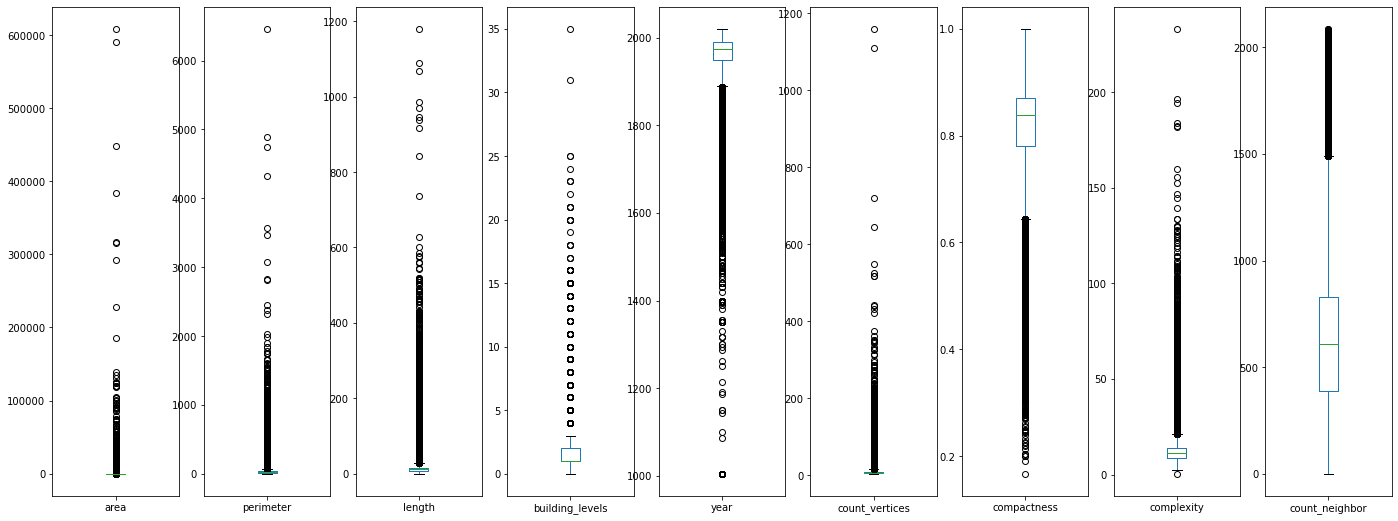

In [15]:
num_df.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('model_performance/run0/noord_holland/exploratory/north_holland_basic_distribution_null.png')

In [16]:
X = ml_df.drop('bldg_height', axis=1).drop(['country', 'state_name'], axis=1).drop(['perimeter'], axis=1)
y = ml_df['bldg_height']
X, y

(                  area     length  building_levels city postcode    year  \
 osm_way_id                                                                 
 265305375    64.001453  13.342338              NaN  NaN      NaN  1880.0   
 272628967    68.886436  15.279231              NaN  NaN      NaN  1911.0   
 272680868    41.360271   9.177766              NaN  NaN      NaN  1949.0   
 284129509    11.620945   4.877114              NaN  NaN      NaN  1903.0   
 273318454   760.358611  52.490301              NaN  NaN      NaN  2012.0   
 ...                ...        ...              ...  ...      ...     ...   
 266621260    31.239681   9.202490              NaN  NaN      NaN  1005.0   
 268999408    34.897699   8.513130              NaN  NaN      NaN  1005.0   
 266660582   117.706685  24.647293              NaN  NaN      NaN  1005.0   
 268459469   583.909571  27.401109              NaN  NaN      NaN  1005.0   
 266551065    75.544314  13.976341              NaN  NaN      NaN  1005.0   

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=train_test_seed)


(                 area     length  building_levels city postcode    year  \
 osm_way_id                                                                
 269237142    9.397988   4.704017              NaN  NaN      NaN  1975.0   
 293025352   65.665709  12.103594              NaN  NaN      NaN  1970.0   
 282663535   48.072919  10.431649              NaN  NaN      NaN  1992.0   
 263902520   98.331731  18.686821              NaN  NaN      NaN  1978.0   
 273614892   62.358067  12.771534              NaN  NaN      NaN  2008.0   
 ...               ...        ...              ...  ...      ...     ...   
 283848908   87.866520  14.095289              NaN  NaN      NaN  2006.0   
 287836938   56.439779  12.410463              NaN  NaN      NaN  1977.0   
 290446069   38.043888   9.349915              NaN  NaN      NaN  1960.0   
 290426596    5.256300   3.354602              NaN  NaN      NaN  1951.0   
 283366416    5.899205   3.571746              NaN  NaN      NaN  1965.0   
 
          

In [17]:
mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler())])

freq_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1, add_indicator=True)),
    ('scaler', StandardScaler())])

zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
    ('scaler', StandardScaler())])

In [18]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [19]:
preprocessor = ColumnTransformer(transformers=[
        ('mean_transformer', mean_transformer, ["year"]),
        ('freq_transformer', freq_transformer, ["building_levels"]),
        ('zero_transformer', zero_transformer, ["count_neighbor"]),
        ('cat_transfomer', cat_transformer, cat_cols)], n_jobs=-1)

In [20]:
regressor = GradientBoostingRegressor(
    n_estimators=500, 
    learning_rate=0.1,
    subsample=0.6,
    max_depth=6,
    max_features=0.4,
    random_state=model_seed)

In [21]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])

In [22]:
pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('mean_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                   

In [23]:
pipeline.score(X, y)

0.19313898521295625

In [24]:
y_pred = pipeline.predict(X)

In [25]:
mae = mean_absolute_error(y, y_pred)
mae

2.782278957653915

In [26]:
mse = mean_squared_error(y, y_pred)
mse

11.72176244700472

In [27]:
y_pred

array([10.55195989, 10.34856927,  5.42907631, ..., 13.32418338,
       14.382709  , 12.97636719])

In [29]:
query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.zeeland_ml_df`
"""

full_df = bq.Client().query(query).to_dataframe()
full_df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
0,271000239,7.29,97.381086,40.700477,14.646597,NaN,None,NL,None,1951.0,9,0.859494,12.956295,15.0,Zeeland
1,282735319,2.59,20.771815,19.258320,7.159732,NaN,None,NL,None,1940.0,5,0.838926,9.020898,528.0,Zeeland
2,276992043,6.54,47.090032,32.392736,10.194386,NaN,None,NL,None,1895.0,12,0.750969,12.365606,784.0,Zeeland
3,284508783,7.47,52.093176,29.361719,10.564820,NaN,None,NL,None,1909.0,5,0.871393,10.929147,544.0,Zeeland
4,272057464,6.88,109.412765,63.250750,23.714024,NaN,None,NL,None,1926.0,14,0.586237,19.556840,223.0,Zeeland


In [30]:
# ml_df = full_df.sample(frac=1, random_state=sampling_seed)
# ml_df.head()

In [31]:
ml_df = full_df
ml_df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
0,271000239,7.29,97.381086,40.700477,14.646597,NaN,None,NL,None,1951.0,9,0.859494,12.956295,15.0,Zeeland
1,282735319,2.59,20.771815,19.258320,7.159732,NaN,None,NL,None,1940.0,5,0.838926,9.020898,528.0,Zeeland
2,276992043,6.54,47.090032,32.392736,10.194386,NaN,None,NL,None,1895.0,12,0.750969,12.365606,784.0,Zeeland
3,284508783,7.47,52.093176,29.361719,10.564820,NaN,None,NL,None,1909.0,5,0.871393,10.929147,544.0,Zeeland
4,272057464,6.88,109.412765,63.250750,23.714024,NaN,None,NL,None,1926.0,14,0.586237,19.556840,223.0,Zeeland


In [32]:
ml_df.set_index('osm_way_id', inplace=True)

ml_df["city"] = ml_df["city"].astype("category")
ml_df["postcode"] = ml_df["postcode"].astype("category")
ml_df["country"] = ml_df["country"].astype("category")
ml_df["state_name"] = ml_df["state_name"].astype("category")

ml_df.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels     float64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [33]:
ml_df.shape

(300756, 14)

In [34]:
ml_df.isna().sum()


bldg_height             0
area                    0
perimeter               0
length                  0
building_levels    298672
city               300552
country                 0
postcode           300699
year                    9
count_vertices          0
compactness             0
complexity              0
count_neighbor        207
state_name              0
dtype: int64

In [35]:
print('unique city:', pd.unique(ml_df['city']))
print('unique postcode:', pd.unique(ml_df['postcode']))

unique city: [NaN, Renesse, Oostburg, Zuidzande, Middelburg, ..., Rilland, Hoek, Yerseke, Westkapelle, IJzendijke]
Length: 22
Categories (21, object): [Renesse, Oostburg, Zuidzande, Middelburg, ..., Hoek, Yerseke, Westkapelle, IJzendijke]
unique postcode: [NaN, 4325AM, 4501PZ, 4501BG, 4374AN, ..., 4331GC, 4332XS, 4462GP, 4325GX, 4374BB]
Length: 35
Categories (34, object): [4325AM, 4501PZ, 4501BG, 4374AN, ..., 4332XS, 4462GP, 4325GX, 4374BB]


In [36]:
label_col = ["bldg_height"]
# num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
cat_cols = ["city", "postcode"]
# cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]

In [37]:
cat_df = ml_df[cat_cols]
num_df = ml_df[num_cols]

In [38]:
num_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,300756.000000,300756.000000,300756.000000,2084.000000,300747.000000,300756.000000,300756.000000,300756.000000,300549.000000
mean,121.129378,38.251493,13.778329,1.818138,1964.911211,7.671807,0.806053,12.453082,443.251819
std,973.451830,36.259477,12.520900,0.453331,42.388767,4.895758,0.078356,4.792757,294.232954
min,0.283780,2.529069,1.019380,1.000000,1012.000000,4.000000,0.243887,3.439193,1.000000
25%,21.826892,19.841580,7.320664,2.000000,1953.000000,5.000000,0.760741,9.141643,213.000000
50%,55.234034,32.349573,11.753707,2.000000,1972.000000,6.000000,0.831837,11.779221,426.000000
75%,92.308083,44.979739,16.189262,2.000000,1990.000000,9.000000,0.869839,14.540793,643.000000
max,176879.905055,2546.474348,673.235330,5.000000,2020.000000,393.000000,0.999789,129.179109,1439.000000


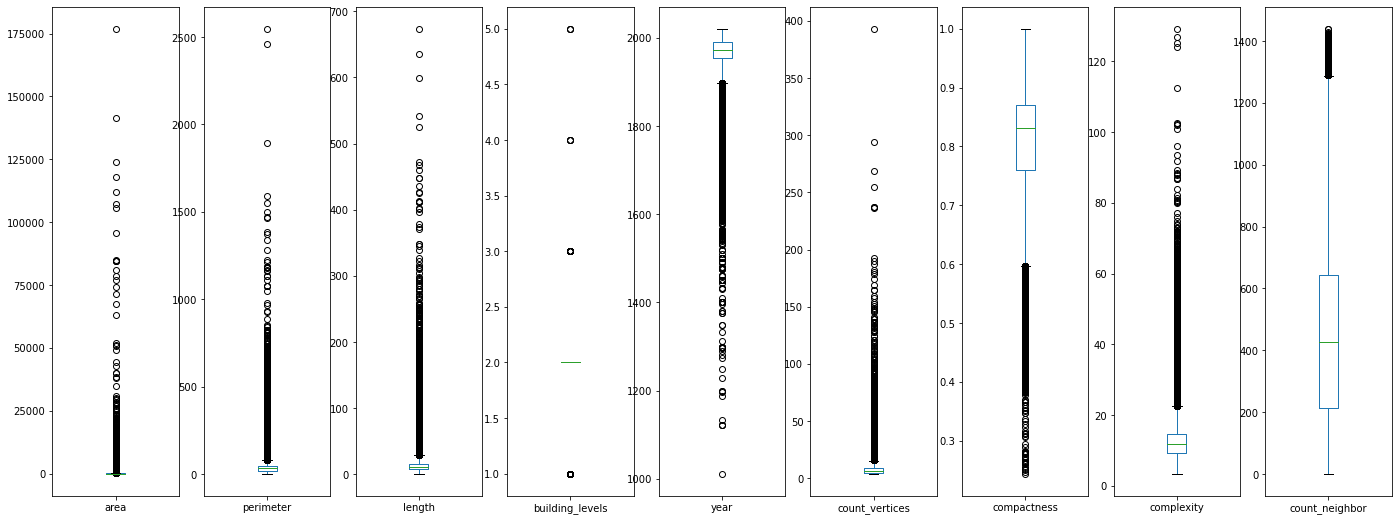

In [39]:
num_df.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('model_performance/run0/zeeland/exploratory/north_holland_basic_distribution_null.png')

In [40]:
X = ml_df.drop('bldg_height', axis=1).drop(['country', 'state_name'], axis=1).drop(['perimeter'], axis=1)
y = ml_df['bldg_height']
X, y

(                  area     length  building_levels city postcode    year  \
 osm_way_id                                                                 
 271000239    97.381086  14.646597              NaN  NaN      NaN  1951.0   
 282735319    20.771815   7.159732              NaN  NaN      NaN  1940.0   
 276992043    47.090032  10.194386              NaN  NaN      NaN  1895.0   
 284508783    52.093176  10.564820              NaN  NaN      NaN  1909.0   
 272057464   109.412765  23.714024              NaN  NaN      NaN  1926.0   
 ...                ...        ...              ...  ...      ...     ...   
 653236501     5.418317   3.437424              NaN  NaN      NaN  2018.0   
 588305830    13.287757   5.159517              NaN  NaN      NaN  2018.0   
 579008764    16.830156   5.803994              NaN  NaN      NaN  2018.0   
 667507147    39.260626  10.144347              NaN  NaN      NaN  2018.0   
 596624419    31.371036   9.632688              NaN  NaN      NaN  2018.0   

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=train_test_seed)


In [42]:
mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler())])

freq_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1, add_indicator=True)),
    ('scaler', StandardScaler())])

zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
    ('scaler', StandardScaler())])

In [43]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [44]:
preprocessor = ColumnTransformer(transformers=[
        ('mean_transformer', mean_transformer, ["year"]),
        ('freq_transformer', freq_transformer, ["building_levels"]),
        ('zero_transformer', zero_transformer, ["count_neighbor"]),
        ('cat_transfomer', cat_transformer, cat_cols)], n_jobs=-1)

In [45]:
regressor = GradientBoostingRegressor(
    n_estimators=500, 
    learning_rate=0.1,
    subsample=0.6,
    max_depth=6,
    max_features=0.4,
    random_state=model_seed)

In [46]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])

In [47]:
pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('mean_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                     

In [48]:
pipeline.score(X, y)

0.17944971464301096

In [49]:
y_pred = pipeline.predict(X)

In [50]:
mae = mean_absolute_error(y, y_pred)
mae

2.137906792375214

In [51]:
mse = mean_squared_error(y, y_pred)
mse

7.068976674351419

In [52]:
y_pred

array([5.78392969, 6.64161329, 7.41285843, ..., 1.47833939, 1.14837917,
       0.93712434])